In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()
np.random.seed(64)

In [2]:
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

import xgboost as xgb
from sklearn.svm import SVC
np.random.seed(64)

In [3]:
def KFold(X, y, model):
    np.random.seed(64)
    train_scores = []
    test_scores = []
    train_logs = []
    test_logs = []
    for train_index, test_index in RepeatedStratifiedKFold(n_splits=5, n_repeats=5).split(X, y):
        x_train, x_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(x_train, y_train)
        pred = model.predict(x_test)

        train_logs.append(metrics.log_loss(y_train, model.predict_proba(x_train)))
        test_logs.append(metrics.log_loss(y_test, model.predict_proba(x_test)))
        train_scores.append(model.score(x_train, y_train))
        test_scores.append(model.score(x_test, y_test))
        
    return train_scores, train_logs, test_scores, test_logs

In [4]:
def test_your_model(X, y ,model):
    x_train, x_test, y_train, y_test = train_test_split(X, y, stratify=y)
    model.fit(x_train, y_train)
    print(model.score(x_train, y_train))
    print(model.score(x_test, y_test))
    print('------------')
    print(metrics.log_loss(y_train, model.predict_proba(x_train)))
    print(metrics.log_loss(y_test, model.predict_proba(x_test)))
    print(metrics.classification_report(y_test, model.predict(x_test)))

In [8]:
train = pd.read_csv('train.csv', dtype = {'Made Donation in March 2007':bool}, index_col=0)

In [9]:
def preprocess_n_engineering(df):
    data = df.copy()
    data.rename({'Months since Last Donation':'Months_since_Last_Donation',
                'Number of Donations':'Number_of_Donations',
                'Total Volume Donated (c.c.)':'Total_Volume_Donated',
                'Months since First Donation':'Months_since_First_Donation',
                'Made Donation in March 2007':'Made_Donation'},
                axis=1, inplace=True)
    
    
    data['months_between_donations'] = data['Months_since_First_Donation'] - data['Months_since_Last_Donation']
    data['month_per_donation'] =  data['months_between_donations'] / data['Number_of_Donations'] # 'average time between donations'
    #     data['mean_volume_per_donation'] = data['Total_Volume_Donated'] / data['Number_of_Donations']
    data['time_to_next_donation'] = data['month_per_donation']  - data['Months_since_Last_Donation']
    data['Is_suppose_to_donate'] = data['time_to_next_donation'].apply(lambda x: x <= 0)
    data.assign(Sholud_have_been_donation = lambda df: df['time_to_next_donation'] > 0)

    return data

In [10]:
train = preprocess_n_engineering(train)

In [12]:
neg_pos = np.sum(train['Made_Donation'] == False) / np.sum(train['Made_Donation'] == True)
neg_pos

3.1739130434782608

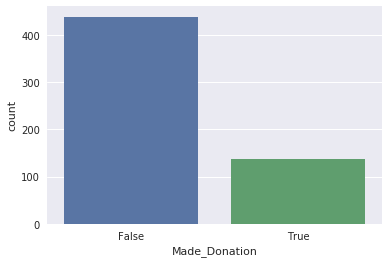

In [11]:
sns.countplot(train['Made_Donation']);

In [13]:
np.random.seed(64)
X = train.drop('Made_Donation', axis=1)
y = train['Made_Donation']

# linear models mabe for an ensemble?

In [47]:
np.random.seed(64)
model = Pipeline(
    [
#         ('scaler', StandardScaler()),
        ('logreg', LogisticRegression(penalty='l2', C=1, class_weight='balanced',
                                      solver='liblinear', max_iter=100))
    ]
)

test_your_model(X, y ,model)

0.6643518518518519
0.5902777777777778
------------
0.581350119833936
0.6676555778951584
             precision    recall  f1-score   support

      False       0.86      0.55      0.67       110
       True       0.33      0.71      0.45        34

avg / total       0.73      0.59      0.62       144



In [32]:
np.random.seed(64)
model = Pipeline(
    [
#         ('scaler', StandardScaler()),
        ('xgb', xgb.XGBClassifier(scale_pos_weight=neg_pos))

    ]
)

test_your_model(X, y ,model)

0.8611111111111112
0.6458333333333334
------------
0.3734742019010742
0.6787769382095171
             precision    recall  f1-score   support

      False       0.82      0.69      0.75       110
       True       0.33      0.50      0.40        34

avg / total       0.70      0.65      0.67       144



/home/ariel/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ariel/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ariel/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [ ]:
np.random.seed(64)

model = Pipeline(
    [
#         ('scaler', StandardScaler()),
        ('RF', RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=10,
                                          min_samples_split=4, min_samples_leaf=2, min_weight_fraction_leaf=0.0,
                                          max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0,
                                          min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=-1,
                                          class_weight=None))
    ]
)
test_your_model(X, y ,model)
# train_scores, train_logs, test_scores, test_logs = KFold(X, y, model)


### Grid Search cv

In [ ]:
from sklearn.model_selection import GridSearchCV

params = {
#     'RF__n_estimators':[10, 50, 100, 200],
    'RF__max_depth':[None, 2, 5, 7, 10, 30],
#     'RF__class_weight':[None, 'balanced'],
#     'RF__max_features':['auto', 0.7, 1.0, 0.5],
    'RF__min_samples_leaf':[4, 5, 6, 7],
    'RF__min_samples_split':[5, 6, 7, 8]
        }

GCV = GridSearchCV(model, params, scoring='neg_log_loss', n_jobs=-1, cv=5, verbose=2)
GCV.fit(X, y)

In [ ]:
GCV.best_params_

In [ ]:
GCV.best_score_

### Log all the data

In [ ]:
np.random.seed(64)
x_train_new, x_test_new, y_train, y_test = train_test_split(X_new, y, stratify=y)
model.fit(x_train_new, y_train)
print(metrics.log_loss(y_train, model.predict_proba(x_train_new)))
print(metrics.log_loss(y_test, model.predict_proba(x_test_new)))
print(metrics.classification_report(y_test, model.predict(x_test_new)))

In [ ]:
f_importance = RandomForestClassifier().fit(x_train, y_train).feature_importances_
pd.DataFrame({'columns':x_train.columns,'scores': f_importance}).sort_values('scores', ascending=False)

### How much the test data differs from the train data
plot both the train and the test after pca in 2d and see the distribution 

In [48]:
test = pd.read_csv('test.csv', index_col=0)
test.head()

,Months since Last Donation,Number of Donations,Total Volume Donated (c.c.),Months since First Donation
659,2,12,3000,52
276,21,7,1750,38
263,4,1,250,4
303,11,11,2750,38
83,4,12,3000,34


In [49]:
model.fit(X, y)
test_proba = model.predict_proba(preprocess_n_engineering(test))

In [56]:
sub = pd.DataFrame(test_proba[:, 1], index=test.index, columns=['Made Donation in March 2007'])